PASO 1: Cargar el dataset

In [1]:
# PASO 1: CARGA DEL DATASET
import pandas as pd

# Ruta del archivo .xlsx desde la estructura del proyecto
ruta = '../data/raw/sismos_completo.xlsx'

# Cargar el archivo
df = pd.read_excel(ruta)

# Ver primeras filas
df.head()


,#,Año,M,D,H,M.1,S,Err.,L,Latitud,Err..1,Longitud,Err..2,Prof.,Err..3,NST,RMS,GAP,ML,Agen.
0,1,2021,1,3,23,35,33.8,0.30,L,-54.804,2.3,-67.206,2.5,0.0,0.0,1,0.0,360,1.6,EAR
1,2,2021,1,26,7,46,42.3,3.16,R,-53.090,36.2,-73.530,80.2,10.0F,0.0,5,1.7,255,3.1,EAR
2,3,2021,1,27,21,46,10.9,0.38,L,-54.689,5.2,-67.467,9.2,9.5,3.7,4,0.1,211,3.1,EAR
3,4,2021,2,8,23,10,31.6,1.00,L,-54.565,4.0,-66.912,8.4,8.4,5.8,7,0.4,180,3.8,EAR
4,5,2021,2,17,2,2,20.8,0.75,R,-54.636,4.9,-69.748,7.0,3.1,7.5,3,0.3,239,2.2,EAR


PASO 2: Explorar datos 

In [3]:
df.columns.tolist()  # Lista las columnas
len(df.columns)      # Cantidad de columnas

df.info() # Ver info general

df.isnull().sum() # Verificar datos nulos


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 20 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   #         240 non-null    int64  
 1   Año       240 non-null    int64  
 2   M         240 non-null    int64  
 3   D         240 non-null    int64  
 4   H         240 non-null    int64  
 5   M.1       240 non-null    int64  
 6   S         240 non-null    float64
 7   Err.      240 non-null    float64
 8   L         240 non-null    object 
 9   Latitud   240 non-null    float64
 10  Err..1    240 non-null    object 
 11  Longitud  240 non-null    float64
 12  Err..2    240 non-null    float64
 13  Prof.     240 non-null    object 
 14  Err..3    240 non-null    float64
 15  NST       240 non-null    int64  
 16  RMS       240 non-null    float64
 17  GAP       240 non-null    int64  
 18  ML        232 non-null    float64
 19  Agen.     232 non-null    object 
dtypes: float64(8), int64(8), object(

#           0
Año         0
M           0
D           0
H           0
M.1         0
S           0
Err.        0
L           0
Latitud     0
Err..1      0
Longitud    0
Err..2      0
Prof.       0
Err..3      0
NST         0
RMS         0
GAP         0
ML          8
Agen.       8
dtype: int64

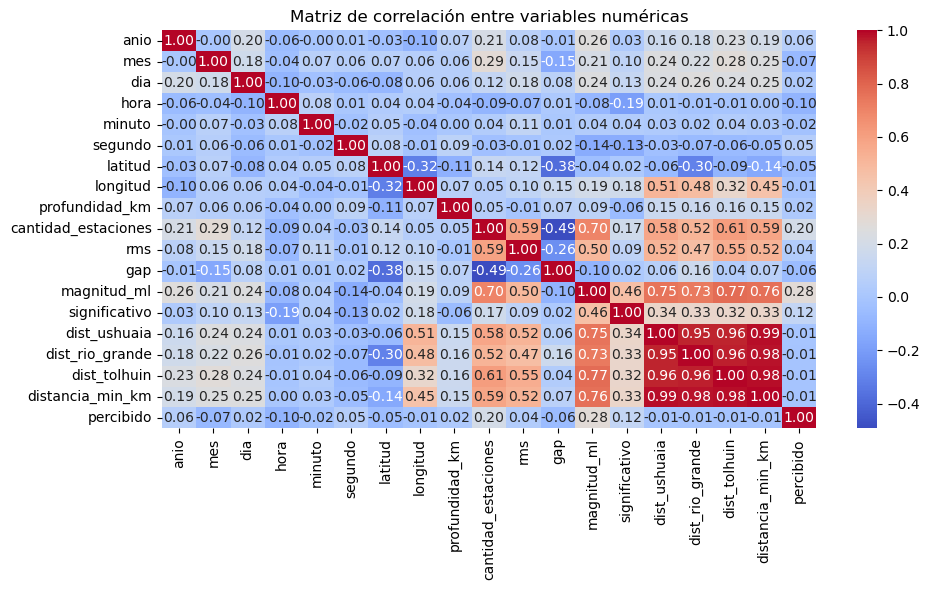

In [45]:
# Gráfico de correlación entre variables
import seaborn as sns
import matplotlib.pyplot as plt

# Gráfico de correlación
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de correlación entre variables numéricas")
plt.tight_layout()
plt.show()


In [5]:
# Ver cuántas filas hay de entrada
len(df)

# Por ejemplo, antes de eliminar filas con letras en 'L'
df['L'].value_counts(dropna=False)

L
R    124
L    115
D      1
Name: count, dtype: int64

In [7]:
# Verificar valores en las columnas que causan error
df['L'].unique()         # distancia_epicentral
df['Err..1'].unique()    # error_latitud
df['Prof.'].unique()     # profundidad_km

array(['0.0', '10.0F', '9.5', '8.4', '3.1', '9.0', '18.2', '12.0F', '6.0',
       '6.2', '8.1', '4.2', '6.1', '6.8', '5.7', '27.0', '18.9', '27.7',
       '12.2F', '11.5', '6.5', '7.9', '1.9', '32.1', '15.0', '5.0',
       '66.7', '10.3', '8.3', '14.5', '16.3', '12.1', '0.4', '12.3',
       '36.9F', '7.7', '4.0', '13.9', '6.9', '30.3', '25.2', '30.7',
       '9.1', '10.0', '10.4', '3.3', '11.9', '22.8', '1.2', '32.3', '8.5',
       '22.0', '14.2', '32.0', '2.9', '5.3', '2.2', '24.5', '7.8', '16.1',
       '15.8', '20.9', '13.0', '1.1', '12.4', '4.1', '10.9', '20.0',
       '20.6', '8.0', '13.6', '3.6', '8.2', '1.5', '115.0', '14.3', '1.6',
       '11.6', '15.7', '18.6', '5.2', '16.7', '29.2', '7.1', '0.7', '4.5',
       '20.7', '18.5', '11.2', '5.8', '24.4', '28.0', '11.0', '13.5',
       '28.9', '10.1', '20.8', '31.8', '16.2', '21.0', '7.0', '11.4F',
       '25.7', '28.6', '9.4', '23.1', '2.7', '32.8', '15.1', '19.5',
       '0.8', '57.0', '6.4', '3.0', '10.8', '12.9', '3.4', '4.8', '

In [9]:
# Renombrar columnas con nombres claros

df.columns = [
    'id', 'anio', 'mes', 'dia', 'hora', 'minuto', 'segundo',
    'error_segundo', 'clasificacion_distancia', 'latitud', 'error_latitud',
    'longitud', 'error_longitud', 'profundidad_km', 'error_profundidad',
    'cantidad_estaciones', 'rms', 'gap', 'magnitud_ml', 'agencia'
]

# Limpiar \"profundidad_km\" (quitar F y comas)
df['profundidad_km'] = df['profundidad_km'].astype(str)
df['profundidad_km'] = df['profundidad_km'].str.replace('F', '', regex=False)
df['profundidad_km'] = df['profundidad_km'].str.replace(',', '.')
df['profundidad_km'] = df['profundidad_km'].astype(float)

# Eliminar filas con ML faltante (NaN o vacías)
df = df[df['magnitud_ml'].notnull()]

# Crear variable objetivo significativo (ML ≥ 4.0)
df['significativo'] = (df['magnitud_ml'] >= 4.0).astype(int)

# Eliminar columnas innecesarias para el modelo
columnas_a_eliminar = [
    'id', 'error_segundo', 'error_latitud', 'error_longitud',
    'error_profundidad', 'agencia'
]
df = df.drop(columns=[col for col in columnas_a_eliminar if col in df.columns])

# Validar estructura
print(df.dtypes)
df.head()
df['significativo'].value_counts(normalize=True)

anio                         int64
mes                          int64
dia                          int64
hora                         int64
minuto                       int64
segundo                    float64
clasificacion_distancia     object
latitud                    float64
longitud                   float64
profundidad_km             float64
cantidad_estaciones          int64
rms                        float64
gap                          int64
magnitud_ml                float64
significativo                int32
dtype: object


significativo
0    0.965517
1    0.034483
Name: proportion, dtype: float64

In [11]:
df.to_csv("df_sismos_limpio.csv", index=False)

In [17]:
from geopy.distance import geodesic

# Incorpore las coordenadas de las 3 ciudades
ushuaia = (-54.8019, -68.3030)
rio_grande = (-53.7877, -67.7095)
tolhuin = (-54.5214, -67.1897)

# Asegurar que las coordenadas sean tipo float
df['latitud'] = df['latitud'].astype(float)
df['longitud'] = df['longitud'].astype(float)

# Calcular distancias
df['dist_ushuaia'] = df.apply(lambda row: geodesic((row['latitud'], row['longitud']), ushuaia).km, axis=1)
df['dist_rio_grande'] = df.apply(lambda row: geodesic((row['latitud'], row['longitud']), rio_grande).km, axis=1)
df['dist_tolhuin'] = df.apply(lambda row: geodesic((row['latitud'], row['longitud']), tolhuin).km, axis=1)

# Agregar columna con distancia mínima
df['distancia_min_km'] = df[['dist_ushuaia', 'dist_rio_grande', 'dist_tolhuin']].min(axis=1)

# Redefinir variable objetivo: percibido (1) / no percibido (0)
df['percibido'] = ((df['magnitud_ml'] >= 3.5) & (df['distancia_min_km'] <= 250)).astype(int)

# Validar conteo
df['percibido'].value_counts(normalize=True)


percibido
0    0.974138
1    0.025862
Name: proportion, dtype: float64

In [15]:
!pip install geopy


In [21]:
# Crea la carpeta data/processed/
import os
os.makedirs("data/processed", exist_ok=True)


# Guardamos esta versión del dataset como df_sismos_modelo.csv para que pueda cargarlo directo al entrenar modelos
df.to_csv("data/processed/df_sismos_modelo.csv", index=False)


In [23]:
# Verificación rápida del archivo guardado
df_check = pd.read_csv("data/processed/df_sismos_modelo.csv")
df_check.head()


,anio,mes,dia,hora,minuto,segundo,clasificacion_distancia,latitud,longitud,profundidad_km,cantidad_estaciones,rms,gap,magnitud_ml,significativo,dist_ushuaia,dist_rio_grande,dist_tolhuin,distancia_min_km,percibido
0,2021,1,3,23,35,33.8,L,-54.804,-67.206,0.0,1,0.0,360,1.6,0,70.544849,117.778402,31.475850,31.475850,0
1,2021,1,26,7,46,42.3,R,-53.090,-73.530,10.0,5,1.7,255,3.1,0,392.410687,394.395223,446.858260,392.410687,0
2,2021,1,27,21,46,10.9,L,-54.689,-67.467,9.5,4,0.1,211,3.1,0,55.284363,101.561310,25.868345,25.868345,0
3,2021,2,8,23,10,31.6,L,-54.565,-66.912,8.4,7,0.4,180,3.8,0,93.508947,100.981357,18.616254,18.616254,1
4,2021,2,17,2,2,20.8,R,-54.636,-69.748,3.1,3,0.3,239,2.2,0,94.928596,163.096422,165.908961,94.928596,0


In [25]:
# Modelado Regresión logística para clasificación binaria 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# 1. Selección de features
X = df[['magnitud_ml', 'profundidad_km', 'distancia_min_km']]
y = df['percibido']

# 2. División en entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 3. Entrenar modelo
modelo_log = LogisticRegression(class_weight='balanced', max_iter=1000)
modelo_log.fit(X_train, y_train)

# 4. Predicción y evaluación
y_pred = modelo_log.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=0))


[[67  1]
 [ 1  1]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        68
           1       0.50      0.50      0.50         2

    accuracy                           0.97        70
   macro avg       0.74      0.74      0.74        70
weighted avg       0.97      0.97      0.97        70



In [27]:
# Instalar SMote
!pip install imbalanced-learn


In [31]:
# Importar Smote
from imblearn.over_sampling import SMOTE


In [35]:
# Aplicar SMOTE al conjunto de entrenamiento
smote = SMOTE(random_state=42, k_neighbors=2)
X_res, y_res = smote.fit_resample(X_train, y_train)

# Entrenar de nuevo el modelo con datos balanceados
modelo_log_res = LogisticRegression(class_weight='balanced', max_iter=1000)
modelo_log_res.fit(X_res, y_res)

# Predecir con el conjunto de test original (sin SMOTE)
y_pred_res = modelo_log_res.predict(X_test)

# Evaluar
print(confusion_matrix(y_test, y_pred_res))
print(classification_report(y_test, y_pred_res, zero_division=0))


[[67  1]
 [ 1  1]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        68
           1       0.50      0.50      0.50         2

    accuracy                           0.97        70
   macro avg       0.74      0.74      0.74        70
weighted avg       0.97      0.97      0.97        70



In [37]:
# Probando con random Forest
from sklearn.ensemble import RandomForestClassifier

# Entrenar el modelo
modelo_rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
modelo_rf.fit(X_res, y_res)

# Predecir sobre el conjunto de test (original, sin SMOTE)
y_pred_rf = modelo_rf.predict(X_test)

# Evaluación
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, zero_division=0))


[[68  0]
 [ 1  1]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        68
           1       1.00      0.50      0.67         2

    accuracy                           0.99        70
   macro avg       0.99      0.75      0.83        70
weighted avg       0.99      0.99      0.98        70



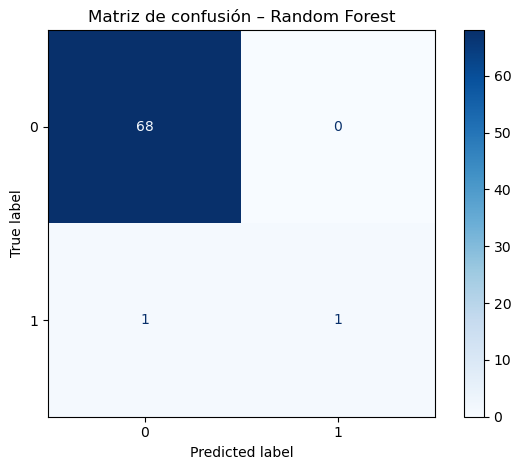

In [47]:
# Gráfico de matriz de confusión
from sklearn.metrics import ConfusionMatrixDisplay

# Matriz de confusión del modelo final
ConfusionMatrixDisplay.from_estimator(modelo_rf, X_test, y_test, cmap='Blues')
plt.title("Matriz de confusión – Random Forest")
plt.tight_layout()
plt.show()


In [39]:
# Código para agregar etiquetas de predicción al dataset completo
# Predecir sobre todo el dataset limpio (sin SMOTE)
df_pred = df.copy()
df_pred['percibido_pred'] = modelo_rf.predict(df[['magnitud_ml', 'profundidad_km', 'distancia_min_km']])

# También podés agregar la probabilidad si querés
df_pred['probabilidad_percibido'] = modelo_rf.predict_proba(df[['magnitud_ml', 'profundidad_km', 'distancia_min_km']])[:,1]

# Guardar
df_pred.to_csv("data/processed/sismos_con_predicciones.csv", index=False)


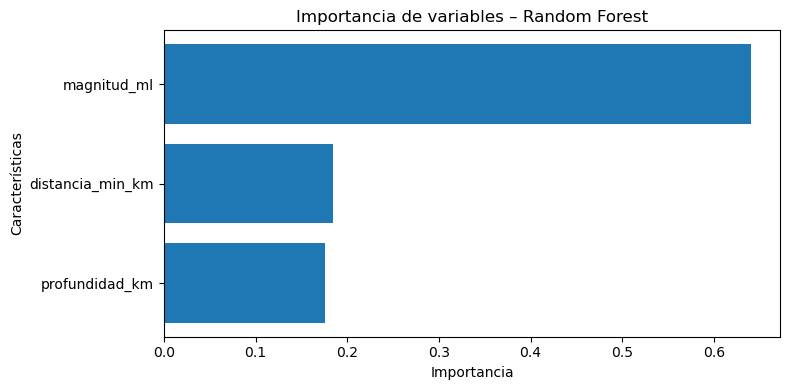

In [41]:
# Gráficos: Importancia de las variables
import matplotlib.pyplot as plt

# Crear dataframe de importancia
importancias = pd.DataFrame({
    'feature': X.columns,
    'importancia': modelo_rf.feature_importances_
}).sort_values(by='importancia', ascending=True)

# Gráfico horizontal
plt.figure(figsize=(8,4))
plt.barh(importancias['feature'], importancias['importancia'])
plt.title("Importancia de variables – Random Forest")
plt.xlabel("Importancia")
plt.ylabel("Características")
plt.tight_layout()
plt.show()


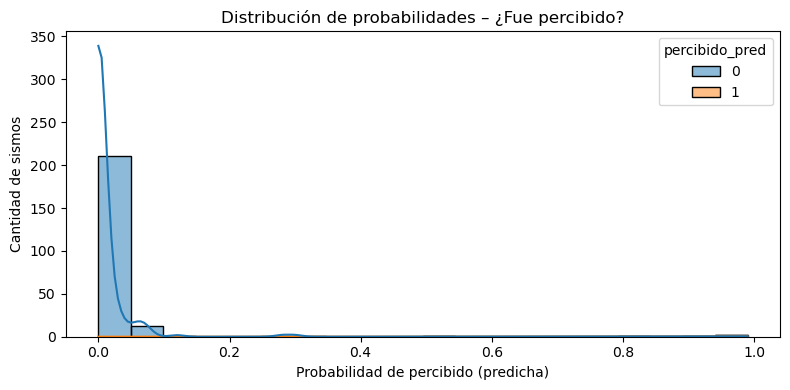

In [43]:
# Gráfico de Predicciones vs Probabilidades
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.histplot(data=df_pred, x='probabilidad_percibido', hue='percibido_pred', bins=20, kde=True, multiple='stack')
plt.title("Distribución de probabilidades – ¿Fue percibido?")
plt.xlabel("Probabilidad de percibido (predicha)")
plt.ylabel("Cantidad de sismos")
plt.tight_layout()
plt.show()
